In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import j0, j1
class Hyperuniform_helper:
    def __init__(self, w_radius, center_pos, positions, rho):
        self.radius = w_radius #  radius of spherical window
        self.positions = positions #  positions of particles in box
        self.center_pos = center_pos #  origin selected
        self.bulk_density = rho #  density in the box

    def select_from_spherial_window(self):
        # this function selects all positions within a hyperspherical window
        squared_distances = np.sum((self.positions - self.center_pos)**2, axis=1)
        selected_positions = self.positions[squared_distances <= self.radius**2]
        return selected_positions
    
    def calculate_radial_distribution(self, num_bins, d=2):
        # This function calculates a discrete g(r) at 0<=r<=R
        selected_pos = self.select_from_spherial_window()
        distances = np.sort(np.linalg.norm(selected_pos-self.center_pos, axis=1))
        r_values = np.linspace(0, self.radius, num_bins+1)
        gr = np.zeros_like(r_values[:-1])

        idx = 0
        shell_volume = 0
        self.bulk_density = len(selected_pos)/(np.pi*self.radius**2)
        if d % 2 == 0:
            self.bulk_density = len(selected_pos)/((np.pi)**(d/2) * (self.radius**d) / math.factorial(d-1))
        else:
            self.bulk_density = (np.pi)**(d/2) * (self.radius**d) / (math.factorial(d+1)/(4**(d/2+1/2)*math.factorial(int(d/2+1/2)))*np.pi**0.5)
        for i in range(len(r_values) - 1):
            count = np.sum((distances[idx+1:] >= r_values[i]) & (distances[idx+1:] <= r_values[i+1]))
            idx += count
            gr[i] = count

            # calculate d-dimensional sphere volumes
            if d % 2 == 0:
                shell_volume = (np.pi)**(d/2) * (-r_values[i]**d + r_values[i+1]**d) / math.factorial(d-1)
            else:
                shell_volume = (np.pi)**(d/2) * (-r_values[i]**d + r_values[i+1]**d) / (math.factorial(d+1)/(4**(d/2+1/2)*math.factorial(int(d/2+1/2)))*np.pi**0.5)

            # Normalize by shell volume and bulk density
            gr[i] = count / (shell_volume * self.bulk_density)
        return r_values[:-1], gr 
    
    def hankel_transform_2d(self, gr, r, k_values):
        hk = np.zeros(len(k_values))
        for i in range(len(k_values)):
            hk[i] = 2*np.pi*np.sum(r*(gr-1)*j0(k_values[i]*r))
        return 1+self.bulk_density*hk
    
    def variance_calculations_in_reciprocal_space_2d(self, sk, k):
        variance_square = self.bulk_density*(1/(2*np.pi)**2*np.sum(sk*2**2*np.pi*1*j1(k*self.radius)**2/(k**2)))
        return variance_square
    

In [2]:
file_name = 'positions.txt'
data = np.loadtxt(file_name)
rho, box_length, volume_fraction = data[0]
helper = Hyperuniform_helper(box_length/2, np.zeros(3), data[1:,], rho)
r, gr = helper.calculate_radial_distribution(40, 2)


0.03072522272728584


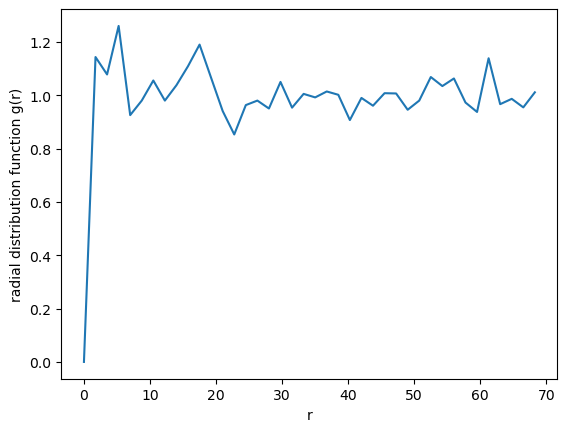

In [7]:
plt.plot(r, gr)
plt.xlabel("r")
plt.ylabel("radial distribution function g(r)")
print(np.sum(r*(gr-1)))

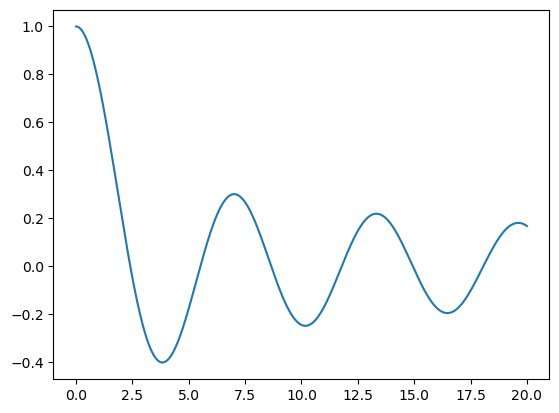

In [4]:
x = np.linspace(0, 20, 1000)
y = j0(x)

plt.plot(x, y)

Text(0, 0.5, 'Structure factor sk')

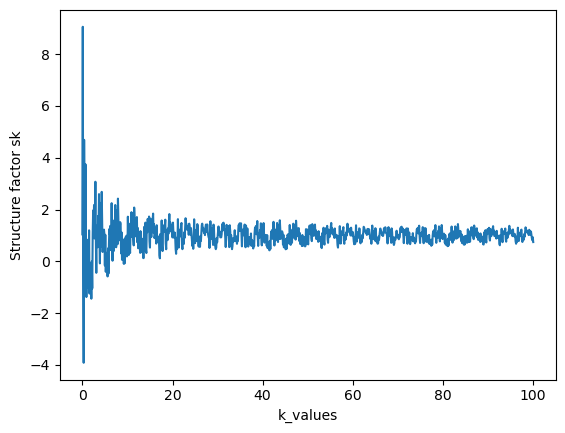

In [8]:
k_values = np.linspace(0.001, 100, 1001)
sk = helper.hankel_transform_2d(gr, r, k_values)
plt.plot(k_values, sk)
plt.xlabel("k_values")
plt.ylabel("Structure factor sk")

In [6]:
variance_square = helper.variance_calculations_in_reciprocal_space_2d(sk, k_values)
print(variance_square)

85.9128149432599
